### Load predictions

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting

reload(misc)
reload(plotting)

first_year = 1990

data_dir = '.'
data_file = os.path.join(data_dir, 'immigration_with_metadata_2017_03_13.csv')

data = misc.read_tone_data(data_file, first_year)

tone_data = misc.read_tone_data(os.path.join(data_dir, 'immigration_tone_annotations.csv'), first_year, include_directness=False)

last_date = data['date'].max()

print "Loaded data for %d articles" % len(data.index)

Loaded data for 34770 articles


### Group data and plot tone and directness

Grouped data into 92 periods
[ 0.2159797   0.27216553  0.20493902  0.17335683  0.20728905  0.17040257
  0.15822229  0.15149     0.21213203  0.19553505  0.14826495  0.17722135
  0.14001281  0.12613014  0.12859269  0.20874927  0.13220065  0.12451076
  0.10347904  0.09919677  0.1261382   0.09899495  0.11845287  0.11706282
  0.09597991  0.09853776  0.09445991  0.11066473  0.10611855  0.08107843
  0.10528606  0.10281842  0.14039943  0.12039871  0.10183502  0.12115737
  0.11229331  0.1357645   0.10712245  0.11201832  0.08902812  0.09067215
  0.10986506  0.12079735  0.10358022  0.09089479  0.07613668  0.08532351
  0.0897415   0.105159    0.08392602  0.09613103  0.09980675  0.10716518
  0.09036573  0.10878566  0.08892318  0.10960728  0.12290729  0.09527775
  0.1144371   0.09219133  0.08689606  0.09108708  0.07744054  0.04971562
  0.07044695  0.07985171  0.08116242  0.06636669  0.08399636  0.07782234
  0.09895372  0.0841955   0.1065125   0.14266801  0.12026637  0.10920943
  0.14242717  0.124870

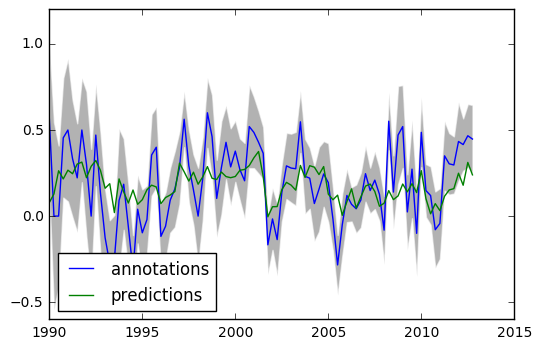

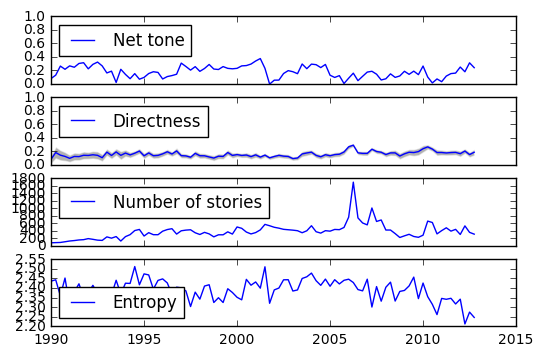

In [19]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'

reload(misc)
reload(plotting)

grouped = misc.group_tone_data(data, group_by)

grouped_annotations = misc.group_tone_data(tone_data, group_by, use_frames=False, use_directness=False)


print "Grouped data into %d periods" % len(grouped.index)

N = grouped_annotations['stories'].values
Pro = grouped_annotations['Pro'].values
Anti = grouped_annotations['Anti'].values
tone = Pro - Anti
tone_sd = np.sqrt((Pro * (1-Pro) + Anti * ( 1- Anti)) / N)
print tone_sd
x = grouped_annotations['x']

print np.min(N), np.mean(N)

fig, ax = plt.subplots()
ax.fill_between(x,  tone+tone_sd*2, tone-tone_sd*2, facecolor='grey', edgecolor='white', alpha=0.6)
ax.plot(x, grouped_annotations['tone'], label='annotations')
ax.plot(grouped['x'], grouped['tone'], label='predictions')
ax.legend(loc='lower left')

plotting.plot_variables(grouped)

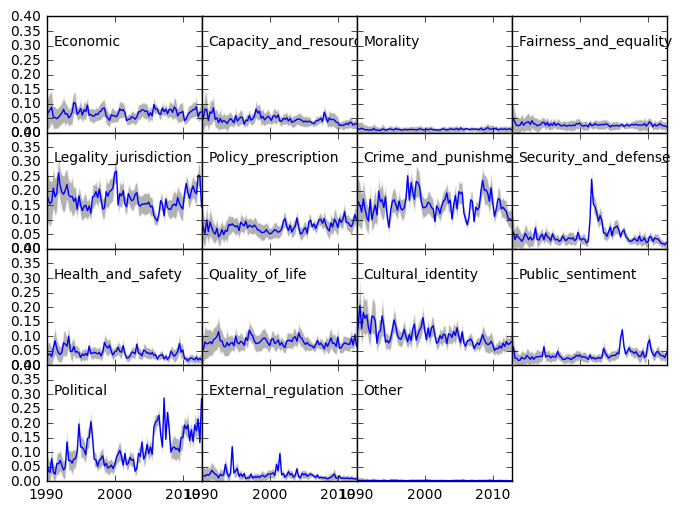

In [89]:
reload(plotting)

plotting.plot_frames(grouped, ymax=0.4)

### Load polling data

In [158]:
reload(misc)

filename = 'immigration_polls.csv'

polls = misc.load_polls(filename, first_year, last_date)
#polls = polls[polls['Varname'] != 'IMMLEGAL']

print "Loaded %d polls" % len(polls.index)
print polls.shape

{'IMMRATE': -38.721666666666678, 'CNNIMM': 1.3933333333333238, 'IMMKEPT': 0, 'IMMIGRAT': 0.1335964912280545, 'SPIMMIG': 34.746666666666663, 'PSRAIMM': -27.498939393939406, 'IMMLEGAL': 3.6473333333333287}
Loaded 89 polls
(89, 30)


(89, 31)


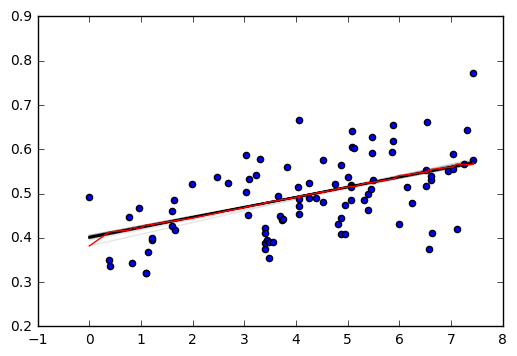

In [163]:
# do a simple linear regression on all polls except one at a time to estiamte tone at each point in time

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

plt.scatter(x, y)

dates = [pd.Timestamp(d) for d in polls['date'].values]
diffs = [(d - dates[0]).days for d in dates]
polls['x'] = np.array(diffs) / 1000.0

print polls.shape 

predictions = []
for i, index in enumerate(polls.index):

    copy = polls.copy()
    copy = copy.drop([index])
    
    fit = pd.ols(y=copy['normalized'], x=copy['x'], weights=copy['N'])
    pred = fit.predict(x=polls['x'])
    predictions.append(pred[index])
    
    plt.plot(polls['x'], pred, c='k', alpha=0.1)
    
polls['linear'] = predictions
plt.plot(polls['x'], polls['linear'], 'r')



misc.py:174: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  polls = polls.sort('date')


(0, 1)

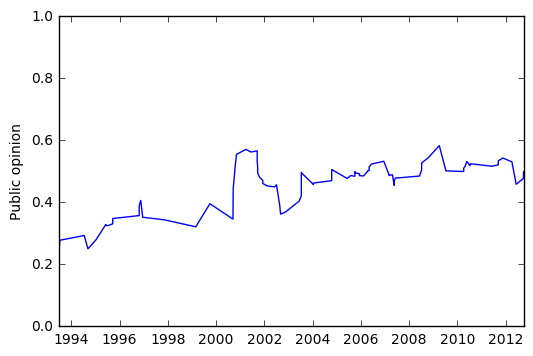

In [164]:
# calculate an exponentially-weighted running average for all polls and plot it

reload(misc)

running_average = misc.calculate_weighted_average(polls)
polls['running_average'] = running_average

plt.plot(polls['date'], polls['running_average']/100.0)
plt.ylabel('Public opinion')
plt.ylim(0, 1)

In [167]:
reload(misc)

combined = misc.combine_polls_with_preceeding_articles(polls, data, n_days=30)
#combined = misc.combine_polls_with_preceeding_articles(polls, tone_data, n_days=30, use_directness=False, use_frames=False)

print combined.describe()

             Pro    Neutral       Anti  directness     stories    entropy  \
count  89.000000  89.000000  89.000000   89.000000   89.000000  89.000000   
mean    0.502242   0.167679   0.330079    0.178782  179.112360   2.384481   
std     0.052139   0.026098   0.050329    0.060032  133.754731   0.060957   
min     0.393174   0.125105   0.221169    0.093515   56.000000   2.240780   
25%     0.470906   0.149957   0.286846    0.139470  112.000000   2.353280   
50%     0.498950   0.159747   0.336236    0.168514  136.000000   2.394584   
75%     0.538220   0.185903   0.356062    0.193006  191.000000   2.422542   
max     0.631303   0.250843   0.433534    0.375660  763.000000   2.488323   

              p0         p1         p2         p3    ...              N  \
count  89.000000  89.000000  89.000000  89.000000    ...      89.000000   
mean    0.068169   0.041193   0.011646   0.028249    ...       0.390878   
std     0.016778   0.011750   0.002989   0.006395    ...       0.188714   
min   

(89, 1)
89
3


ValueError: x and y must be the same size

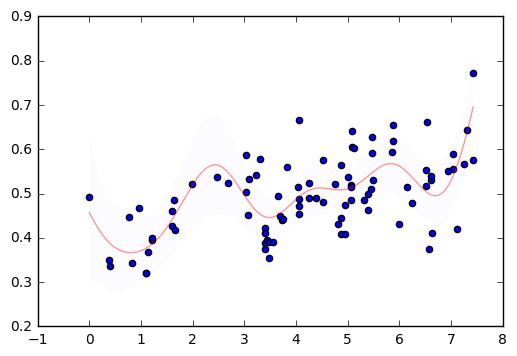

In [125]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

dates = [pd.Timestamp(d) for d in combined['date'].values]
diffs = [(d - dates[0]).days for d in dates]
x = np.array(diffs) / 1000.0

X = np.atleast_2d(x).T

#poll_names = ['PSRAIMM', 'SPIMMIG', 'IMMRATE', 'CNNIMM', 'IMMLEGAL']
#poll_names = misc.get_top_poll_questions(polls)[1:]
#X = np.hstack([X, combined[poll_names].as_matrix()])
print X.shape

y = combined['normalized'].values
plt.scatter(x, y)

#for i in range(2, len(y)):
predictions = [np.NaN, np.NaN]
sigmas = [np.NaN, np.NaN]
for i in range(len(y)-1, len(y)):
    gp = GaussianProcessRegressor(normalize_y=True, alpha=0.01)

    gp.fit(X[:i, :], y[:i])

    n_pred_points = i*5
    x_pred = np.atleast_2d(np.linspace(x[0], x[i], n_pred_points)).T
    X_pred = x_pred
    #X_pred = np.hstack([x_pred, np.zeros([n_pred_points, len(poll_names)])])

    y_pred, sigma = gp.predict(X_pred, return_std=True)
    plt.plot(X_pred, y_pred, 'r-', label=u'Prediction', alpha=0.4)
    plt.fill(np.concatenate([X_pred, X_pred[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.01, fc='b', ec='None', label='95% confidence interval')
    predictions.append(y_pred[-1])
    sigmas.append(sigma[-1])
    
print len(x)
print len(predictions)
plt.scatter(x, predictions, c='r')
plt.ylim(0, 1)
combined['gp_pred'] = predictions
combined['sigmas'] = sigmas

### Plot polling data

Question	Responses
 IMMKEPT	24
IMMLEGAL	20
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3



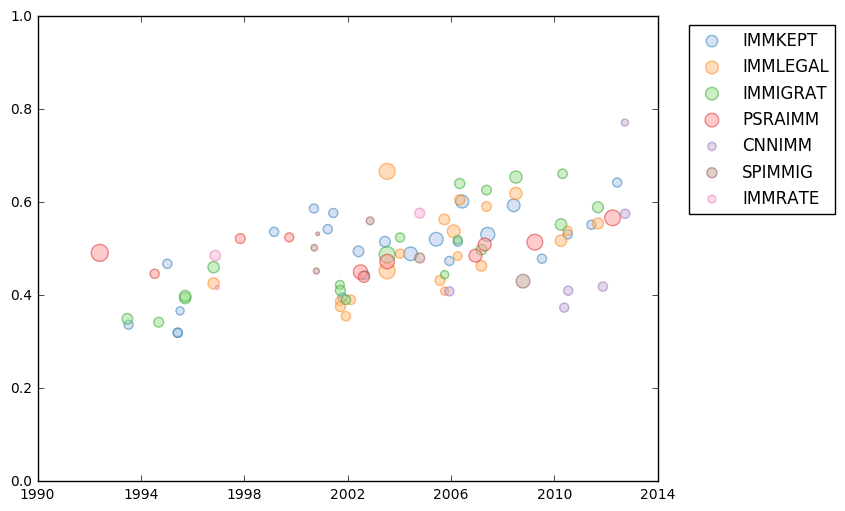

In [168]:
reload(plotting)

plotting.plot_polling_data(combined, plot_gp_pred=False)

print ""

In [61]:
# create a "salient" variable that is 1 if the number of stories per quarter >= 350, otherwise 0
combined['salient'] = combined.apply(lambda row: int(row['stories'] >= 170), axis=1)

combined['toneXstories'] = combined['tone'] * combined['stories']


In [187]:
# create a "salient" variable that is 1 if the number of stories per quarter >= 350, otherwise 0
combined['salient'] = combined.apply(lambda row: int(row['stories'] >= 170), axis=1)

combined['toneXstories'] = combined['tone'] * combined['stories']
combined['directnessXstories'] = combined['directness'] * combined['stories']

combined['proXstories'] = combined['Pro'] * combined['stories']
combined['antiXstories'] = combined['Anti'] * combined['stories']
combined['neutralXstories'] = combined['Neutral'] * combined['stories']

combined['entropyXstories'] = combined['entropy'] * combined['stories']
combined['entropyXtone'] =  combined['entropy'] * combined['tone']
combined['entropyXtoneXstories'] =  combined['entropy'] * combined['tone'] * combined['stories']

combined['toneXdirectness'] = combined['tone'] * combined['directness']
combined['toneXdirectnessXstories'] = combined['tone'] * combined['directness'] * combined['stories']

combined['entropyXtoneXdirectness'] = combined['entropy'] * combined['tone'] * combined['directness']


combined['toneXsalient'] = combined['tone'] * combined['salient']
combined['directnessXsalient'] = combined['directness'] * combined['salient']

combined['logStories'] = np.mean(combined['stories'])
combined['toneXlogStories'] = combined['tone'] * combined['logStories']
combined['entropyXtoneXlogStories'] = combined['entropy'] * combined['tone'] * combined['logStories']

combined['invlog_y'] = np.exp(combined['normalized'].values) / (1 - np.exp(combined['normalized'].values))

#for year in range(1990,2014):
#    combined['post_' + str(year)] = [int(combined.index[i][0] > year) for i in range(len(combined.index))]    
    
#combined['post_event_1990'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 1991) for i in range(len(combined.index))]
#combined['post_event_1994'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 1995) for i in range(len(combined.index))]
#combined['post_event_2000'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2000.5) for i in range(len(combined.index))]
#combined['post_event_2001'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2002) for i in range(len(combined.index))]
#combined['post_event_2006'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2006.5) for i in range(len(combined.index))]


In [63]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM>
             + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   8

R-squared:         0.7720
Adj R-squared:     0.7522

Rmse:              0.0525

F-stat (7, 81):    39.1695, p-value:     0.0000

Degrees of Freedom: model 7, resid 81

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.2261     0.0582       3.89     0.0002     0.1121     0.3401
       IMMKEPT     0.3669     0.0322      11.40     0.0000     0.3038     0.4300
      IMMLEGAL     0.4052     0.0325      12.46     0.0000     0.3414     0.4690
      IMMIGRAT     0.3535     0.0327      10.82     0.0000     0.2895   

In [145]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT>
             + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   9

R-squared:         0.8017
Adj R-squared:     0.7816

Rmse:              0.0480

F-stat (8, 79):    39.9258, p-value:     0.0000

Degrees of Freedom: model 8, resid 79

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4632     0.0676       6.85     0.0000     0.3306     0.5958
          tone     0.2408     0.0548       4.39     0.0000     0.1334     0.3483
       IMMKEPT     0.3674     0.0294      12.49     0.0000     0.3097     0.4250
      IMMLEGAL     0.3916     0.0300      13.05    

In [48]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['gp_pred', 'tone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <gp_pred> + <tone> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT>
             + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         87
Number of Degrees of Freedom:   9

R-squared:         0.7998
Adj R-squared:     0.7793

Rmse:              0.0484

F-stat (8, 78):    38.9519, p-value:     0.0000

Degrees of Freedom: model 8, resid 78

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
       gp_pred     0.3423     0.0561       6.10     0.0000     0.2324     0.4522
          tone     0.0527     0.0203       2.60     0.0112     0.0129     0.0925
       IMMKEPT     0.3340     0.0304      10.99     0.0000     0.2744     0.3936
      IMMLEGAL     0.3656     0.0311      11.77     0.0000  

In [49]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit

KeyError: "['entropy'] not in index"

In [71]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <entropy> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   10

R-squared:         0.8164
Adj R-squared:     0.7953

Rmse:              0.0465

F-stat (9, 78):    38.5473, p-value:     0.0000

Degrees of Freedom: model 9, resid 78

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4219     0.0664       6.36     0.0000     0.2918     0.5520
          tone     0.2999     0.0553       5.42     0.0000     0.1915     0.4083
       entropy    -0.3707     0.0913      -4.06     0.0001    -0.5497    -0.1916
       IMMKEPT     0.3748     0.0285  

In [72]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <entropy> + <entropyXtone> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   10

R-squared:         0.8228
Adj R-squared:     0.8026

Rmse:              0.0469

F-stat (9, 79):    40.7505, p-value:     0.0000

Degrees of Freedom: model 9, resid 79

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone    14.3057     2.1346       6.70     0.0000    10.1218    18.4896
       entropy     0.4627     0.1680       2.75     0.0073     0.1335     0.7919
  entropyXtone    -5.9148     0.9032      -6.55     0.0000    -7.6850    -4.1446
       IMMKEPT     0.3215     0.0293      

In [73]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <entropy> + <entropyXtone> + <IMMKEPT>
             + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   11

R-squared:         0.8523
Adj R-squared:     0.8331

Rmse:              0.0420

F-stat (10, 77):    44.4348, p-value:     0.0000

Degrees of Freedom: model 10, resid 77

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4664     0.0607       7.69     0.0000     0.3475     0.5853
          tone    15.4785     1.9513       7.93     0.0000    11.6539    19.3031
       entropy     0.6307     0.1556       4.05     0.0001     0.3258     0.9357
  entr

In [50]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <toneXstories> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM>
             + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   8

R-squared:         0.7730
Adj R-squared:     0.7534

Rmse:              0.0524

F-stat (7, 81):    39.4058, p-value:     0.0000

Degrees of Freedom: model 7, resid 81

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
  toneXstories     0.0043     0.0011       3.94     0.0002     0.0022     0.0065
       IMMKEPT     0.3628     0.0321      11.30     0.0000     0.2998     0.4257
      IMMLEGAL     0.3929     0.0326      12.06     0.0000     0.3290     0.4568
      IMMIGRAT     0.3401     0.0328      10.37     0.0000     0

In [51]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <toneXstories> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   9

R-squared:         0.7981
Adj R-squared:     0.7777

Rmse:              0.0484

F-stat (8, 79):    39.0440, p-value:     0.0000

Degrees of Freedom: model 8, resid 79

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4579     0.0689       6.64     0.0000     0.3228     0.5930
  toneXstories     0.0037     0.0010       3.57     0.0006     0.0017     0.0057
       IMMKEPT     0.3645     0.0297      12.28     0.0000     0.3063     0.4227
      IMMLEGAL     0.3826     0.0304      1

In [52]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT>
             + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   9

R-squared:         0.7792
Adj R-squared:     0.7571

Rmse:              0.0520

F-stat (8, 80):    35.2873, p-value:     0.0000

Degrees of Freedom: model 8, resid 80

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.0859     0.0209       4.11     0.0001     0.0450     0.1268
       stories     0.0008     0.0004       2.03     0.0458     0.0000     0.0015
       IMMKEPT     0.3551     0.0322      11.04     0.0000     0.2921     0.4182
      IMMLEGAL     0.3899     0.0327      11.94     0.0000  

In [53]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'stories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   10

R-squared:         0.7996
Adj R-squared:     0.7764

Rmse:              0.0486

F-stat (9, 78):    34.5731, p-value:     0.0000

Degrees of Freedom: model 9, resid 78

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4340     0.0704       6.17     0.0000     0.2961     0.5720
          tone     0.0707     0.0198       3.57     0.0006     0.0319     0.1095
       stories     0.0004     0.0004       1.16     0.2490    -0.0003     0.0011
       IMMKEPT     0.3606     0.0300  

In [54]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <toneXstories> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   10

R-squared:         0.7792
Adj R-squared:     0.7540

Rmse:              0.0524

F-stat (9, 79):    30.9760, p-value:     0.0000

Degrees of Freedom: model 9, resid 79

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.0830     0.0417       1.99     0.0499     0.0013     0.1647
       stories     0.0008     0.0005       1.62     0.1087    -0.0002     0.0017
  toneXstories     0.0002     0.0023       0.08     0.9354    -0.0043     0.0047
       IMMKEPT     0.3552     0.0325      

In [55]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'stories', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <toneXstories> + <IMMKEPT>
             + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   11

R-squared:         0.8000
Adj R-squared:     0.7741

Rmse:              0.0488

F-stat (10, 77):    30.8051, p-value:     0.0000

Degrees of Freedom: model 10, resid 77

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4392     0.0710       6.19     0.0000     0.3002     0.5783
          tone     0.0498     0.0393       1.26     0.2098    -0.0274     0.1269
       stories     0.0003     0.0004       0.67     0.5061    -0.0006     0.0012
  tone

In [80]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <entropy> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   10

R-squared:         0.8005
Adj R-squared:     0.7777

Rmse:              0.0498

F-stat (9, 79):    35.2139, p-value:     0.0000

Degrees of Freedom: model 9, resid 79

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.3012     0.0572       5.26     0.0000     0.1890     0.4134
       stories     0.0001     0.0000       2.88     0.0051     0.0000     0.0002
       entropy    -0.4365     0.0965      -4.52     0.0000    -0.6257    -0.2474
       IMMKEPT     0.3648     0.0307      11.89

In [81]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <entropy> + <IMMKEPT>
             + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   11

R-squared:         0.8188
Adj R-squared:     0.7952

Rmse:              0.0465

F-stat (10, 77):    34.7906, p-value:     0.0000

Degrees of Freedom: model 10, resid 77

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.3972     0.0681       5.83     0.0000     0.2637     0.5308
          tone     0.3049     0.0554       5.50     0.0000     0.1963     0.4135
       stories     0.0001     0.0000       1.63     0.1073    -0.0000     0.0001
       entr

In [82]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'toneXstories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <toneXstories> + <entropy> + <entropyXtone>
             + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM>
             + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   12

R-squared:         0.8296
Adj R-squared:     0.8052

Rmse:              0.0466

F-stat (11, 77):    34.0688, p-value:     0.0000

Degrees of Freedom: model 11, resid 77

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone    14.1346     2.1246       6.65     0.0000     9.9703    18.2988
       stories     0.0001     0.0001       1.57     0.1202    -0.0000     0.0003
  toneXstories    -0.0002     0.0004      -0.37     0.7147    -0.0010     0.000

In [83]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories', 'toneXstories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <toneXstories> + <entropy>
             + <entropyXtone> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM>
             + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   13

R-squared:         0.8539
Adj R-squared:     0.8305

Rmse:              0.0423

F-stat (12, 75):    36.5297, p-value:     0.0000

Degrees of Freedom: model 12, resid 75

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4492     0.0636       7.06     0.0000     0.3246     0.5739
          tone    15.3129     1.9691       7.78     0.0000    11.4535    19.1724
       stories     0.0000     0.0001       0.33     0.7397

In [27]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <entropy> + <entropyXtone> + <IMMKEPT>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         69
Number of Degrees of Freedom:   10

R-squared:         0.8684
Adj R-squared:     0.8483

Rmse:              0.0433

F-stat (9, 59):    43.2430, p-value:     0.0000

Degrees of Freedom: model 9, resid 59

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone    12.1884     2.1230       5.74     0.0000     8.0272    16.3496
       stories     0.0002     0.0000       3.49     0.0009     0.0001     0.0002
       entropy     0.3293     0.1714       1.92     0.0596    -0.0067     0.6652
  entropyXtone    -5.0178     0.8990      -

In [125]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <entropy> + <entropyXtone>
             + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <IMMRATE> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   12

R-squared:         0.8538
Adj R-squared:     0.8327

Rmse:              0.0420

F-stat (11, 76):    40.3571, p-value:     0.0000

Degrees of Freedom: model 11, resid 76

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4460     0.0624       7.14     0.0000     0.3237     0.5684
          tone    15.3258     1.9566       7.83     0.0000    11.4908    19.1607
       stories     0.0001     0.0000       1.45     0.1509    -0.0000     0

In [148]:
poll_names = misc.get_top_poll_questions(polls, n=25)[1:]
columns = ['gp_pred', 'tone', 'stories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <gp_pred> + <tone> + <stories> + <entropy> + <entropyXtone>
             + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <IMMRATE>
             + <intercept>

Number of Observations:         87
Number of Degrees of Freedom:   12

R-squared:         0.8532
Adj R-squared:     0.8317

Rmse:              0.0423

F-stat (11, 75):    39.6394, p-value:     0.0000

Degrees of Freedom: model 11, resid 75

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
       gp_pred     0.2817     0.0508       5.54     0.0000     0.1820     0.3813
          tone    13.9042     1.9469       7.14     0.0000    10.0883    17.7201
       stories     0.0001     0.0000       2.20     0.0306     0.0000     0.0001
   

In [85]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <entropy> + <entropyXtone> + <IMMKEPT>
             + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   11

R-squared:         0.8523
Adj R-squared:     0.8331

Rmse:              0.0420

F-stat (10, 77):    44.4348, p-value:     0.0000

Degrees of Freedom: model 10, resid 77

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4664     0.0607       7.69     0.0000     0.3475     0.5853
          tone    15.4785     1.9513       7.93     0.0000    11.6539    19.3031
       entropy     0.6307     0.1556       4.05     0.0001     0.3258     0.9357
  entr

In [143]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['gp_pred', 'tone', 'stories', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <gp_pred> + <tone> + <stories> + <toneXstories> + <IMMKEPT>
             + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         87
Number of Degrees of Freedom:   11

R-squared:         0.8034
Adj R-squared:     0.7776

Rmse:              0.0486

F-stat (10, 76):    31.0627, p-value:     0.0000

Degrees of Freedom: model 10, resid 76

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
       gp_pred     0.3170     0.0585       5.42     0.0000     0.2024     0.4315
          tone     0.1543     0.1054       1.46     0.1475    -0.0524     0.3610
       stories     0.0001     0.0001       0.91     0.3642    -0.0001     0.0003
  toneXstories     0.0000   

In [193]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
frames = ['p2', 'p3', 'p6', 'p7', 'p8', 'p10']  # Morality, Fairness, Crime, Security, Health, Culture
#frames = ['p4', 'p6', 'p7', 'p12'] 
columns = ['linear', 'tone', 'stories', 'entropy']
fit = pd.ols(y=combined['normalized'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <linear> + <tone> + <stories> + <entropy> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   5

R-squared:         0.3482
Adj R-squared:     0.3172

Rmse:              0.0434

F-stat (4, 84):    11.2209, p-value:     0.0000

Degrees of Freedom: model 4, resid 84

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
        linear     0.8817     0.1147       7.69     0.0000     0.6569     1.1065
          tone     0.2991     0.0485       6.17     0.0000     0.2041     0.3942
       stories     0.0001     0.0000       2.36     0.0207     0.0000     0.0002
       entropy    -0.1606     0.0840      -1.91     0.0592    -0.3252     0.0040
     intercept     0.3758     0.2247      